# Theoretical validation of Snowslide outputs in the Argentiere basin

The steep, long slopes surrounding the Argentiere basin are ideal for avalanches. This glacier is also part of the Glacioclim [1] measurement programme, and a large number of observations are made on it every year, using an extensive database. There is also work available on identifying avalanche deposits from measurements on Sentinel1 satellite images (2017-2021) to compare and test the output results of our algorithm [2]. For all these reasons, we decided to test the adequacy of the data between Snowslide output and Sentinel-1 observations specifically on the Argentiere glacier. To do this, we initialise the precipitation using SAFRAN reanalysis data [3] and run simulations using monthly aggregated data. The aim of this notebook is to guide and explain this comparison work in order to test the relevance of snowslide in the representation of avalanches on glaciers.

In [2]:
# Importations
import os
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import snowslide 
from snowslide.preprocess_data import initialize_snowslide_from_safran

In [3]:
os.chdir("/Users/llemcf/Desktop/Stage_IGE_2023/GitHub_snowslide/snowslide/example")

### 1) Downloading and initializing weather data 

The weather data has been downloaded beforehand to make it easier to use. An automatic download function from the aeris_data interface should be available shortly. From the weather files (one netcdf file per year) we can use the ``initialize_snowslide_from_safran`` function available in the ``preprocess_data.py`` file. This function automates the pre-processing of xarray files to produce height matrices of identical size to the dem at a frequency chosen by the user. The default initialisation frequency is monthly. It is useful because preprocessing requires familiarisation with the altitude band products of SAFRAN s2m simulations and a certain number of processing operations before use. However, users can use their own weather data. 

In [2]:
ds_paths = ["tests/tests_data/SAFRAN_2017080106_2018080106.nc",
         "tests/tests_data/SAFRAN_2018080106_2019080106.nc",
         "tests/tests_data/SAFRAN_2019080106_2020080106.nc",
         "tests/tests_data/SAFRAN_2020080106_2021080106.nc",
         "tests/tests_data/SAFRAN_2021080106_2022080106.nc"]

dem_path = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/comparaison_sentinel/Input/dem.tif"
dem = rasterio.open(dem_path).read(1)
prcpt = initialize_snowslide_from_safran(dem_path,ds_paths)

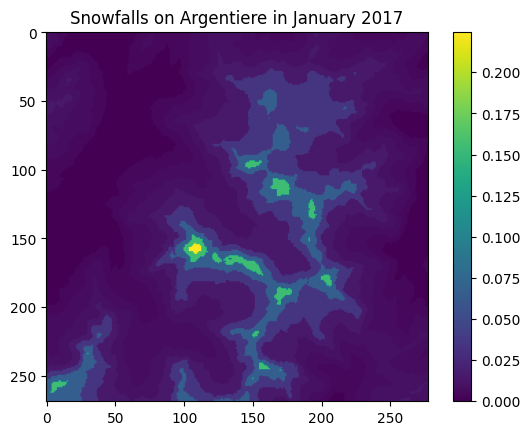

In [3]:
# Plotting code
plt.imshow(prcpt[0])
plt.title("Snowfalls on Argentiere in January 2017")
plt.colorbar()

<font color='red'> Attention : Cela ne fonctionne que pour les versions 1.5.3 de pandas. Avec la version ultérieure, le resampling ne fonctionne pas bien (problème avec l'argument base)

### 2) Launching simulation over 5 years

In [4]:
import snowslide
from  snowslide.snowslide_main import snowslide_base

In [5]:
SND_final = np.zeros(np.shape(prcpt))
mask_final = np.zeros(np.shape(prcpt))
i = 0
total_iterations = len(ds_paths) * 12
for year in range(len(ds_paths)):
    snd = np.zeros(np.shape(dem))
    for month in range(12):
        snd0 = prcpt[i]
        snd_month = snowslide_base(dem_path,snd0=snd0)
        snd_month[np.where(snd_month <= snd0)] = 0.
        snd = snd + snd_month
        i=i+1
    SND_final[year] = snd

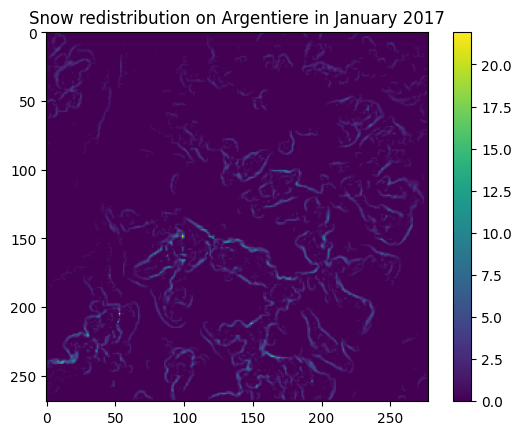

In [6]:
# Plotting code
plt.imshow(SND_final[0])
plt.title("Snow redistribution on Argentiere in January 2017")
plt.colorbar()

In order to compare the monthly results with the detection of avalanche deposits over 5 years from Sentinel1 images, we create a single avalanche deposit map. We therefore create a matrix taking the maximum deposits over the 5 years. We then normalise the result to get an idea of the percentage of deposits. 

In [7]:
# Calculating 1 maximum deposit matrix over the 5 years 
raster = [elt for elt in SND_final]
final = np.maximum.reduce(raster)

# Normalising the results
max = np.max(final)
final = final/max

Text(0.5, 1.0, 'Maximum normalised avalanche deposits 2017-2021 \n SAFRAN initialisation')

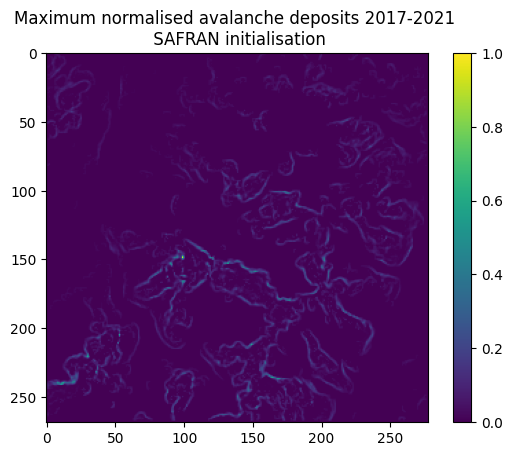

In [8]:
# Plotting code
plt.imshow(final)
plt.colorbar()
plt.title("Maximum normalised avalanche deposits 2017-2021 \n SAFRAN initialisation")

### 3) Comparison with sentinel1 maps of avalanches deposits

In order to compare the results with those of the heat_maps from the sentinel1 images, we first need to transform our avalanche deposits from the model into a mask in order to make geometric comparisons of the deposits. In particular, we filter out deposits of less than 5% (normalised) to remove information that is not very useful. The heat maps then need to be pre-processed so that they can be superimposed on the snowslide results by aggregating the up and down heat maps and removing insignificant deposits from the maps. We then cross-reference the two maps of deposits with the same dimensions (windows with the same geographical coordinates) and we can then carry out our comparison by superposition.

#### 3.1 - Processing snowslide outputs

In [9]:
# Filtering snowslide deposits
mask_aval = final > 0.05
ss_depo = np.copy(mask_aval.astype(float))
ss_depo[np.where(ss_depo ==0)] = np.NaN

Text(0.5, 1.0, 'Maximum normalised avalanche deposits \n by snowslide filtering 5%')

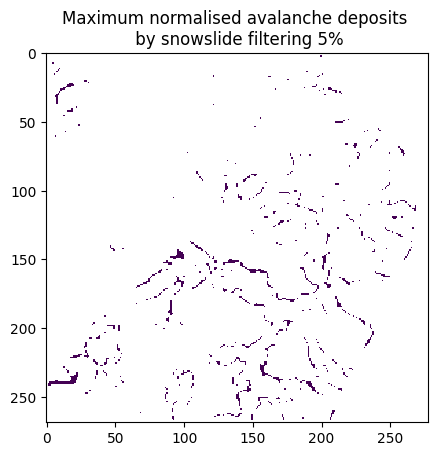

In [10]:
# Plotting code
plt.imshow(ss_depo)
plt.title("Maximum normalised avalanche deposits \n by snowslide filtering 5%")

#### 3.2 - Processing sentinel1 heat_maps outputs

In [11]:
# Defining paths
hm_path_asc = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/comparaison_sentinel/Input/Depots_avalanches_Marin/Heat_map_ASC.tif"
hm_path_desc = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/comparaison_sentinel/Input/Depots_avalanches_Marin/Heat_map_DESC.tif"
mask1_path = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/comparaison_sentinel/Input/Depots_avalanches_Marin/SA_MtBlanc_ASC.tif"
mask2_path = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/comparaison_sentinel/Input/Depots_avalanches_Marin/SA_MtBlanc_DESC.tif"

# Opening files
hm1 = rasterio.open(hm_path_asc).read(1)
hm2 =rasterio.open(hm_path_desc).read(1)
mask1 = rasterio.open(mask1_path).read(1)
mask2 = rasterio.open(mask2_path).read(1)
transform = rasterio.open(hm_path_asc).transform
crs = rasterio.open(hm_path_asc).crs

# Processing the heat_maps into an avalanche deposit mask
hm = hm1 + hm2
hm[np.where(hm==0)]=np.nan
hm[np.where(mask1==0)]=np.nan
hm[np.where(mask2==0)]=np.nan
hm[np.where(hm>0)]=1

Text(0.5, 1.0, 'Avalanche deposit maps over Mont_blanc \n from Sentinel1 images [2]')

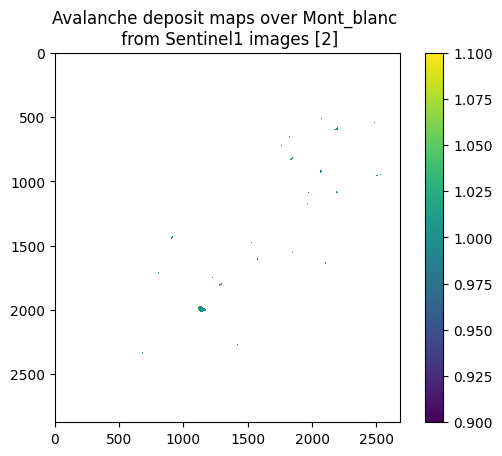

In [12]:
# Plotting code
plt.imshow(hm)
plt.colorbar()
plt.title("Avalanche deposit maps over Mont_blanc \n from Sentinel1 images [2]")

#### 3.3 - Refocusing data on the Argentiere glacier

In [13]:
# importing snowslide built-in functions
from snowslide.preprocess_data import *

In [14]:
# Saving outputs as .tif files with an EPSG:4326 Coordinate Projection System (can be chosen by the user)
output_path_sentinel = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/deposit_sentinel.tif"
store_output_as_raster(output_path_sentinel,hm_path_asc,hm,epsg="EPSG:4326")

output_path_snowslide = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/deposit_snowslide.tif"
store_output_as_raster(output_path=output_path_snowslide,input_path=dem_path,matrix=ss_depo,epsg="EPSG:4326")

In [15]:
# Cropping the results to the bounds of the dem coordinates window
left,bottom,right,top = rasterio.open(output_path_snowslide).bounds
deposit_sentinel = crop_tif_from_coordinates_window(output_path_sentinel,left,right,bottom,top,output_path=output_path_sentinel)
deposit_snowslide = crop_tif_from_coordinates_window(output_path_snowslide,left,right,bottom,top,output_path=output_path_snowslide)

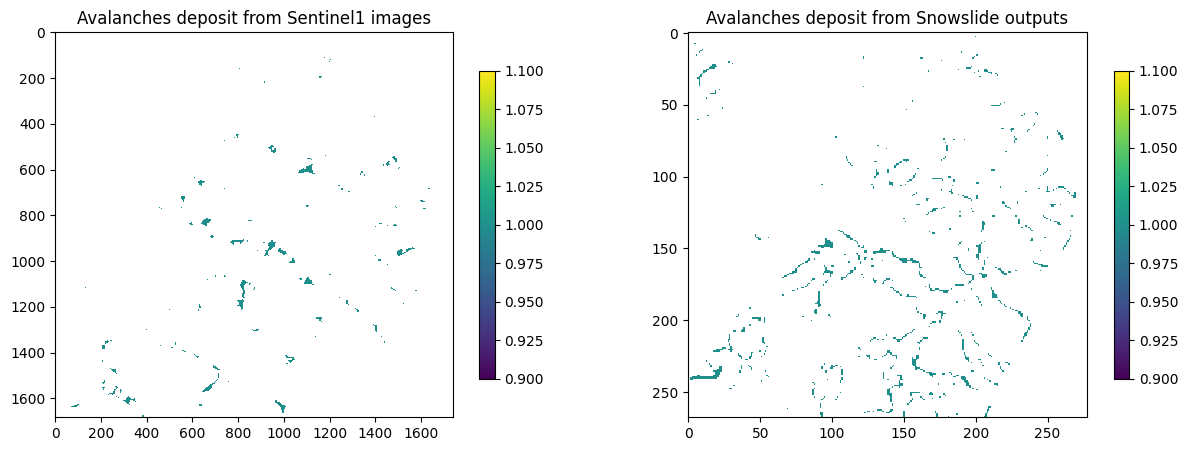

In [16]:
# Plotting code
fig, ax = plt.subplots(1,2,figsize=(15,5))
deposit_sentinel = rasterio.open(output_path_sentinel).read(1)
plot1 = ax[0].imshow(deposit_sentinel)
ax[0].set_title('Avalanches deposit from Sentinel1 images')
plt.colorbar(plot1,ax=ax[0],shrink=0.8)

deposit_snowslide = rasterio.open(output_path_snowslide).read(1)
plot2 = ax[1].imshow(deposit_snowslide)
ax[1].set_title('Avalanches deposit from Snowslide outputs')
plt.colorbar(plot2,ax=ax[1],shrink=0.8)

#### 3.4 - Aesthetic display and comparison of results

It is possible to export these maps and open them with GIS software in order to superimpose and make a comparison, which offers numerous (simple and rapid) possibilities for reprocessing the outputs. However, we can do this directly with the following lines.

In [17]:
# # Resampling and degradation of the resolution of sentinel1 products
dst_path = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/deposit_sentinel_resampled.tif"
factor = (np.shape(deposit_snowslide)[0]/np.shape(deposit_sentinel)[0] + np.shape(deposit_snowslide)[1]/np.shape(deposit_sentinel)[1])/2
src_path = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/deposit_sentinel.tif"

deposit_sentinel = resampling_dem(src_path, dst_path, factor,resampling="nearest")

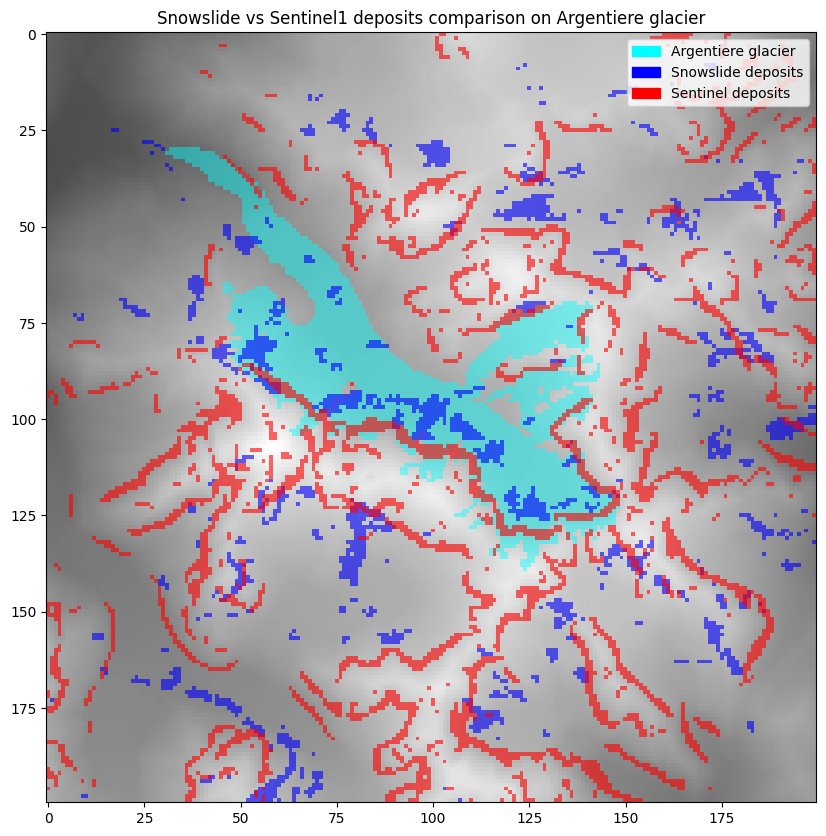

In [107]:
# plotting
import matplotlib.patches as mpatches
glacier_mask_path = "/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/glacier_mask_argentiere.tif"

plt.figure(figsize=(10,10))
plt.imshow(rasterio.open(dem_path).read(1)[50:250,50:250],cmap='gray',alpha=0.7)
plt.imshow(rasterio.open(glacier_mask_path).read(1)[50:250,50:250],cmap='cool',alpha=0.45)
plot1=plt.imshow(deposit_sentinel[50:250,50:250],cmap='winter',alpha=0.6)
plot2=plt.imshow(deposit_snowslide[50:250,50:250],cmap='autumn',alpha=0.6)
plt.title('Snowslide vs Sentinel1 deposits comparison on Argentiere glacier')
legend_mask1 = mpatches.Patch(color='cyan', label='Argentiere glacier')
legend_mask2 = mpatches.Patch(color='blue', label='Snowslide deposits')
legend_mask3 = mpatches.Patch(color='red', label='Sentinel deposits')
plt.legend(handles=[legend_mask1,legend_mask2,legend_mask3], loc='upper right')

Creating an attractive but simple display in Python is no easy task. Although some initial conclusions can be drawn, we have produced figures by exporting the data and processing them with GIS software. The following figure is an example.

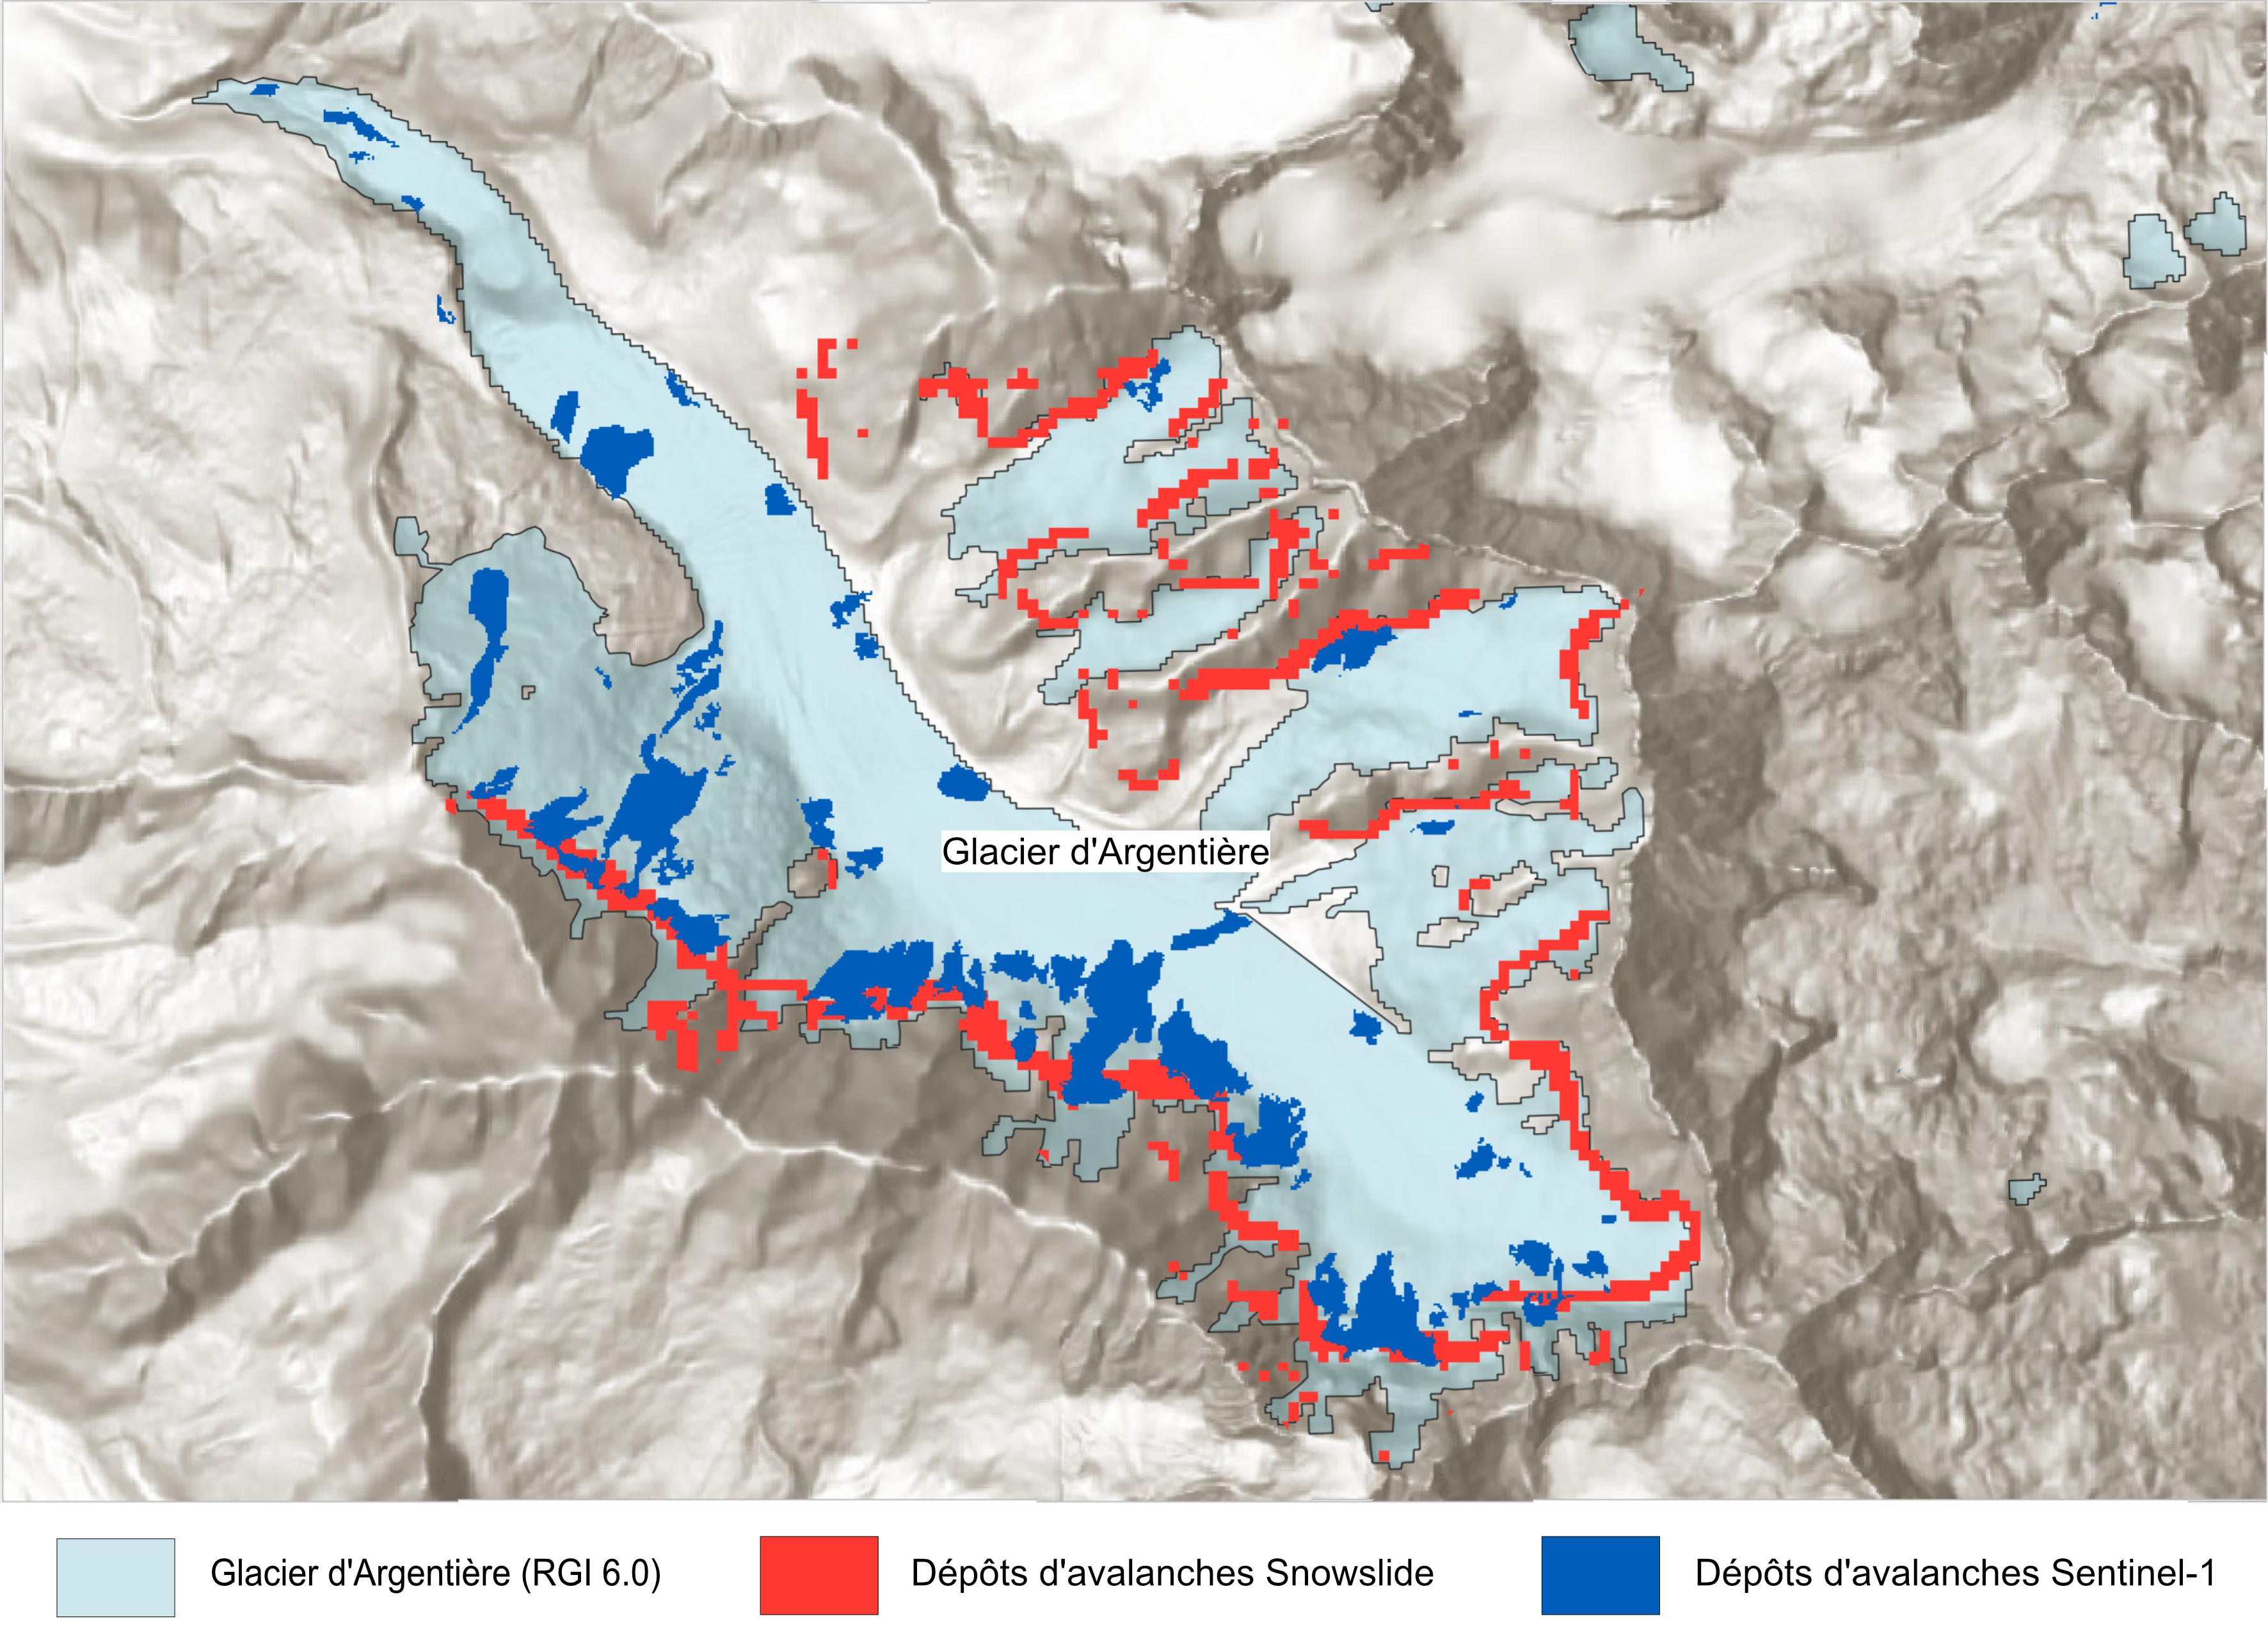

As might be expected, there is no perfect superposition of the Snowslide deposits and the deposits observed with Sentinel-1. This is to be expected, as our model is largely idealised and only gives an idea of where avalanches are most likely to deposit snow according to strictly topographical rules. Furthermore, as our model does not incorporate a kinetic concept, we can see that the deposits proposed by Snowslide are much less extensive in the direction of the slope than the actual deposits observed. Snowslide therefore almost systematically proposes a redistribution that is further upstream than reality. At the foot of the northern faces of the Argentière basin, the start of the Snowslide and sentinel-1 deposits coincide well and the model seems to work as expected. As for the south-facing faces, since the model is based on topographical information, it also suggests a redistribution of snow which, however, is not observed for the most part with the sentinel-1 observation data. This can be interpreted in several ways: either Snowslide proposes an overestimate of avalanche phenomena, or the orientation of these faces means that avalanches have indeed been triggered but that the deposits under the influence of the sun have evolved and are not classified as avalanche deposits by the algorithm used to generate the Sentinel deposit mask.

### 4 - Comparison of deposits in 1D aggregation by altitude bands


The importance of the extent of deposition, where Snowslide makes a notable error, can be put into perspective by considering that its application is for flowline-type glaciology models. This means that the glacier is represented in 1D by a flowline and that the values are averaged (or integrated) by altitude bands. The sentinel-1 deposits are certainly more extensive, but often in directions transverse to the flowline, which should give a similar result between Snowslide and sentinel-1 once the values have been aggregated into altitude bands. This is what we do in the following code cells.

In [116]:
gridded_data = xr.open_dataset("/Users/llemcf/Desktop/Stage_IGE_2023/Notebooks_package/Test_argentiere/gridded_data_argentiere.nc")

#  Creating 30m bins based on dem altitudes
bin_index = 30
dem_masked = gridded_data.topo.where(gridded_data.glacier_mask == 1).values
min = np.nanmin(dem_masked)
max = np.nanmax(dem_masked)
bins = np.arange(min,max+bin_index,bin_index)
index = np.digitize(dem_masked,bins)

# Counting number of pixels corresponding to deposit for each altitude band
ss_flowline = []
sentinel_flowline = []
for i in range(len(bins)) :
    
    ss = np.nansum(deposit_snowslide[np.where(index == i)])
    ss_flowline.append(ss)

    sentinel = np.nansum(deposit_sentinel[np.where(index == i)])
    sentinel_flowline.append(sentinel)

Text(0.5, 1.0, 'Number of pixels associated with a deposit by aggregation into altitude bands')

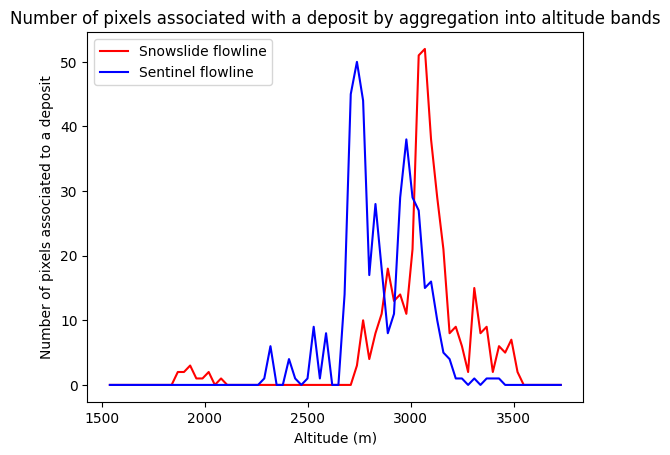

In [118]:
# Plotting code
ss_flowline = np.array(ss_flowline)
ss_flowline[np.where(ss_flowline < 1)] = 0.0
sentinel_flowline = np.array(sentinel_flowline)
sentinel_flowline[np.where(sentinel_flowline < 1)] = 0.0
plt.plot(bins,ss_flowline,label='Snowslide flowline', c = 'red')
plt.plot(bins,sentinel_flowline,label='Sentinel flowline',c = 'blue')
plt.legend()
plt.xlabel('Altitude (m)')
plt.ylabel('Number of pixels associated to a deposit')
plt.title("Number of pixels associated with a deposit by aggregation into altitude bands")

For each 30m altitude band, we sum up the number of pixels associated with an avalanche deposit for the Snowslide and sentinel-1 outputs. Although the curves do not merge perfectly, we can see a similar trend between the two, but with the actual deposits shifted further downstream. This confirms our observations that Snowslide tends to produce deposits too far "upstream" because of the routing rules. We also consider that in current line aggregation (different from altitude band aggregation), these differences between sentinel-1 and Snowslide would be even more blurred. Overall, this validates the operation of Snowslide.

# Bibliography
[1] - https://glacioclim.osug.fr
<br> [2] - Kneib M., Dehecq A., Brun F. Et al. (2023). Mapping and characteristics of avalanches on mountain glaciers with Sentinel-1.https://doi.org/10.5194/egusphere-2023-2007.
<br> [3] - https://www.aeris-data.fr/en/landing-page/?uuid=865730e8-edeb-4c6b-ae58-80f95166509b#v2020.2